# CNN on Oxford Flowers 102

In this notebook, I build a Convolutional Neural Network (CNN) to classify images from the Oxford Flowers 102 dataset. I'm running this on Google Colab with GPU acceleration to speed up training. I'll document each step in detail, explaining my choices and analysis along the way.


In [ ]:
# Importing necessary libraries

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Checking for GPU availability
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Using GPU: {device_name}")
else:
    print("GPU not found. Please enable GPU in Colab settings.")


Using GPU: /device:GPU:0


## Loading the Dataset

I am loading the Oxford Flowers 102 dataset using TensorFlow Datasets (TFDS). TFDS simplifies the process by providing train, validation, and test splits, which helps me quickly get started with exploring the data.


In [ ]:
# Load the Oxford Flowers 102 dataset from TFDS

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Print dataset information to understand its structure
print(ds_info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.WZD6G5_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.WZD6G5_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.WZD6G5_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

## Preprocessing the Data

To prepare the data for training, I need to preprocess the images. I resize each image to a fixed size and normalize the pixel values. This step ensures that the input to the CNN is consistent, which helps in achieving better model performance.


In [ ]:
# Define image dimensions and batch size

IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    # Resize image to the target size
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normalize image to the range [0,1]
    image = image / 255.0
    return image, label

# Apply preprocessing to the datasets
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## Building the CNN Model

Here, I design my CNN architecture using Keras. The model starts with a few convolutional layers for feature extraction, followed by dense layers for classification. I chose this architecture as a balance between complexity and performance for the dataset.


In [ ]:
# Retrieve the number of classes from the dataset info
num_classes = ds_info.features['label'].num_classes

# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with an optimizer, loss function, and evaluation metrics
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │          13,158 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,182,118 (42.66 MB)

 Trainable params: 11,182,118 (42.66 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

I now train the CNN using the training set while monitoring its performance on the validation set. The number of epochs is set to 10 for initial experimentation, but I might adjust it later based on the results.


In [ ]:
# Train the model
EPOCHS = 10

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.0091 - loss: 4.8941 - val_accuracy: 0.0108 - val_loss: 4.5539
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.0189 - loss: 4.4987 - val_accuracy: 0.0255 - val_loss: 4.3095
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.0498 - loss: 4.0850 - val_accuracy: 0.0794 - val_loss: 4.0658
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.1981 - loss: 3.4097 - val_accuracy: 0.1020 - val_loss: 4.0600
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.3981 - loss: 2.4061 - val_accuracy: 0.1206 - val_loss: 4.2599
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.6154 - loss: 1.5107 - val_accuracy: 0.1284 - val_loss: 5.4858
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8115 - loss: 0.7728 - val_accuracy: 0.1265 - val_loss: 6.5732
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9151 - loss: 0.3449 - val_accuracy: 

## Evaluating the Model

After training, I evaluate the model on the test set to see how well it generalizes to new data. I also plot the training and validation accuracy and loss to visually assess the learning progress.


193/193 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.1139 - loss: 8.6765
Test Accuracy: 0.12


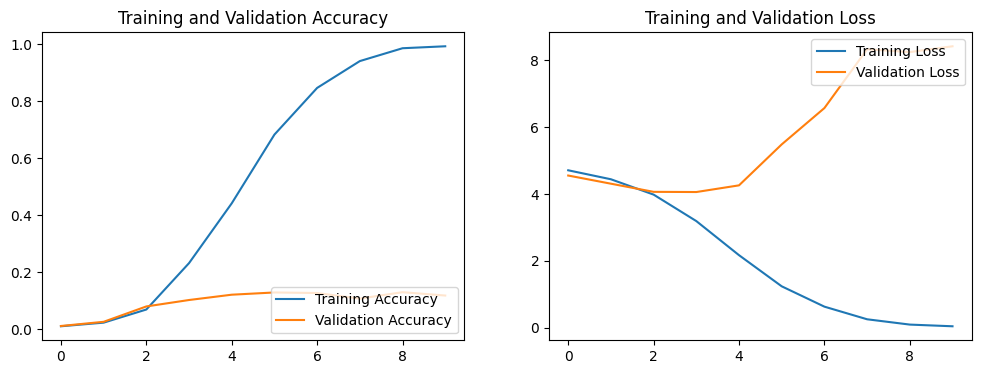

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


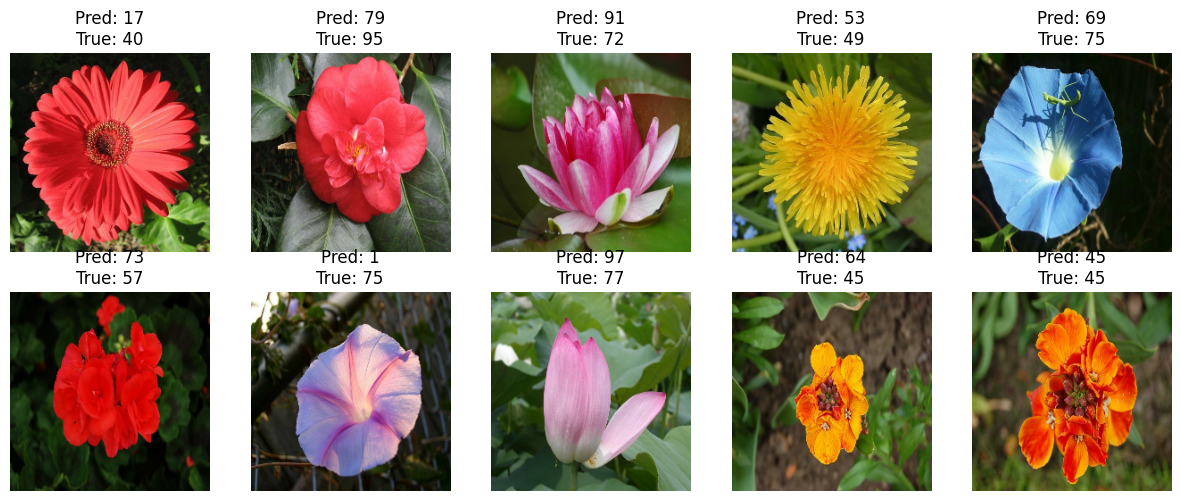

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Take one batch of images from the test dataset
for test_images, test_labels in ds_test.take(1):
    # Generate predictions for the batch
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Display 10 images from the batch with their true and predicted labels
    plt.figure(figsize=(15, 15))
    for i in range(min(10, test_images.shape[0])):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(test_images[i])
        plt.title(f"Pred: {predicted_labels[i]}\nTrue: {test_labels[i].numpy()}")
        plt.axis("off")
    plt.show()


## Results and Next Steps

Looking at the training process, I can see that the training accuracy skyrocketed from around 1% to almost 99% by the final epoch, whereas the validation accuracy stayed around 10–13%. This huge gap indicates severe overfitting: the model is memorizing the training data but failing to generalize to unseen data. The test accuracy of about 12% further confirms this issue.

From the sample predictions, it’s clear that the model struggles to predict the correct flower class for most test images. Despite achieving near-perfect accuracy on the training set, the model’s performance on validation and test sets is quite poor.

### Possible Reasons for Overfitting
- **Model Complexity:** The CNN may have too many parameters relative to the amount and variety of data.
- **Insufficient Regularization:** There may not be enough techniques (like dropout, weight decay, or data augmentation) to prevent overfitting.
- **Data Distribution or Label Issues:** It’s worth verifying that the data is correctly labeled and that the train/validation/test splits are balanced.
- **Limited Data or Variety:** If the dataset is too small or not diverse enough, the model can easily memorize training examples.

## Conclusion and Next Steps

The results clearly indicate that while the model is learning the training data very well, it is severely overfitting, as evidenced by the high training accuracy contrasted with the low validation and test accuracies. To address this issue, the next step I'm taking is to integrate data augmentation and add regularization techniques (such as dropout) to the model. These strategies are expected to improve generalization by introducing more variety in the training data and preventing the model from memorizing the training samples. This adjustment will be crucial for boosting the model’s performance on unseen data.


## Integrating Data Augmentation and Dropout Regularization

To improve the model's generalization and reduce overfitting, I am adding a data augmentation pipeline to increase the effective training data variety. Additionally, I will include a dropout layer in the model architecture to help prevent overfitting by randomly deactivating neurons during training. The goal of these adjustments is to encourage the model to learn more robust and generalized features.


In [ ]:
# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Build a new CNN model with data augmentation and dropout regularization
new_model = tf.keras.Sequential([
    # Apply data augmentation. Note: When using data augmentation within the model,
    # it applies only during training.
    data_augmentation,

    # Convolutional layers for feature extraction
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # Dropout layer for regularization (drop 50% of the neurons during training)
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the new model
new_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary to check the architecture
new_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training the Improved Model

Now, I will train the new model with data augmentation and dropout. I expect these modifications to help the model generalize better to the validation and test data. I will use the same training, validation, and test splits, and keep the training for 10 epochs for this experiment.


In [ ]:
# Train the improved model
EPOCHS = 10

history_new = new_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.0080 - loss: 4.8465 - val_accuracy: 0.0235 - val_loss: 4.6073
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.0137 - loss: 4.5971 - val_accuracy: 0.0235 - val_loss: 4.5073
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.0285 - loss: 4.4959 - val_accuracy: 0.0265 - val_loss: 4.3945
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.0283 - loss: 4.3903 - val_accuracy: 0.0578 - val_loss: 4.2157
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.0250 - loss: 4.2599 - val_accuracy: 0.0647 - val_loss: 4.1179
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.0290 - loss: 4.2703 - val_accuracy: 0.0706 - val_loss: 4.0433
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.0371 - loss: 4.1251 - val_accuracy: 0.0794 - val_loss: 3.9340
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.0617 - loss: 4.1036 - val_accuracy: 0

## Evaluating the Improved Model

After training, I'll evaluate the improved model on the test dataset and compare its performance against the previous model. I will also visualize the training history (accuracy and loss) to monitor improvements in generalization.


193/193 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.1092 - loss: 3.7091
New Test Accuracy: 0.11


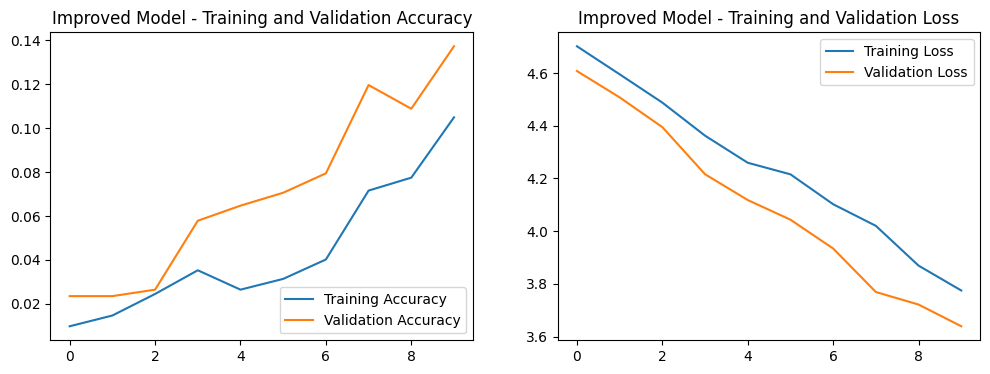

In [ ]:
# Evaluate the improved model on the test set
test_loss_new, test_accuracy_new = new_model.evaluate(ds_test)
print(f"New Test Accuracy: {test_accuracy_new:.2f}")

# Plot the training history for the improved model
acc_new = history_new.history['accuracy']
val_acc_new = history_new.history['val_accuracy']
loss_new = history_new.history['loss']
val_loss_new = history_new.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_new, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_new, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Improved Model - Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_new, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_new, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Improved Model - Training and Validation Loss')
plt.show()


## Testing the Improved Model Predictions

Now, I will select a batch of images from the test set and generate predictions using the improved model. This will allow me to visually inspect whether the data augmentation and dropout regularization have helped the model generalize better.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


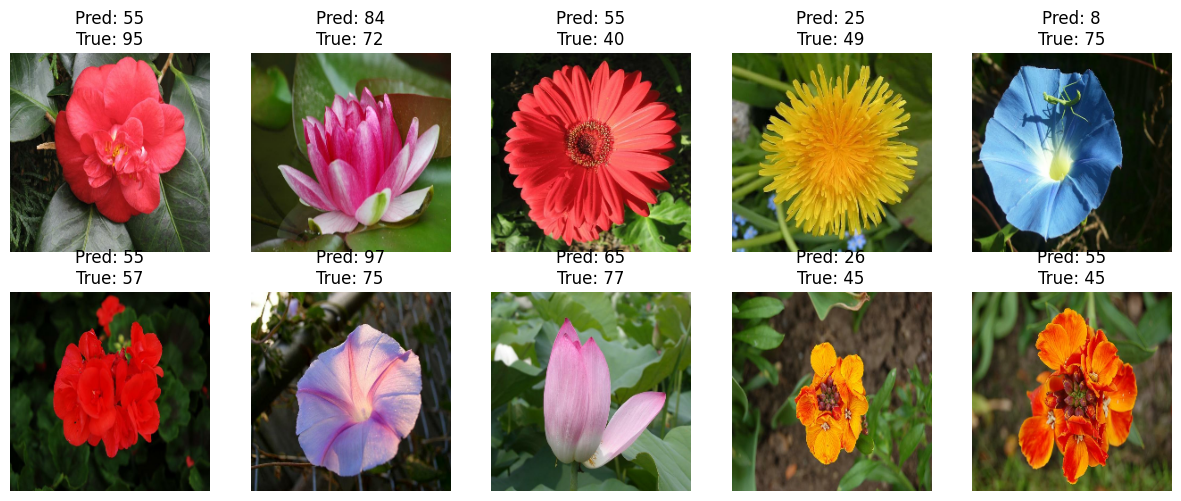

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Take one batch of images from the test dataset for the improved model
for test_images, test_labels in ds_test.take(1):
    # Generate predictions for the batch using the improved model
    predictions_new = new_model.predict(test_images)
    predicted_labels_new = np.argmax(predictions_new, axis=1)

    # Display 10 images from the batch with their true and predicted labels
    plt.figure(figsize=(15, 15))
    for i in range(min(10, test_images.shape[0])):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(test_images[i])
        plt.title(f"Pred: {predicted_labels_new[i]}\nTrue: {test_labels[i].numpy()}")
        plt.axis("off")
    plt.show()


## Updated Results Analysis

After incorporating data augmentation and dropout, the model’s training and validation accuracies both remain relatively low, indicating that the model is still struggling to learn discriminative features effectively. The final test accuracy hovers around 11%, which is slightly lower than or comparable to our previous attempt without these additional regularization techniques.

### Observations
- **Lower Overfitting:** Unlike before, the model no longer shows extreme overfitting, as training accuracy is also relatively low. However, it’s still not learning robust features to distinguish flower classes effectively.
- **Possible Underfitting:** The model may be underfitting the data. This can happen when the network capacity or training setup is insufficient to capture the complexity of the dataset.


In [ ]:
import collections
import pandas as pd

def count_labels(dataset):
    """Unbatch the dataset and count the number of samples for each label."""
    counts = collections.Counter()
    for image, label in dataset.unbatch():
        counts[int(label)] += 1
    return counts

# Count samples for each dataset split
train_counts = count_labels(ds_train)
val_counts = count_labels(ds_val)
test_counts = count_labels(ds_test)

# Get the label names from the dataset info
label_names = ds_info.features['label'].names

# Create a DataFrame to display counts for each flower type
data = {
    "Flower Type": [label_names[i] for i in range(len(label_names))],
    "Train": [train_counts[i] for i in range(len(label_names))],
    "Validation": [val_counts[i] for i in range(len(label_names))],
    "Test": [test_counts[i] for i in range(len(label_names))]
}

df_counts = pd.DataFrame(data)
df_counts.sort_values(by="Flower Type", inplace=True)
df_counts


,Flower Type,Train,Validation,Test
34,alpine sea holly,10,10,23
79,anthurium,10,10,85
28,artichoke,10,10,58
71,azalea,10,10,76
92,ball moss,10,10,26
...,...,...,...,...
72,water lily,10,10,174
88,watercress,10,10,164
51,wild pansy,10,10,65
68,windflower,10,10,34


from matplotlib import pyplot as plt
df_counts['Test'].plot(kind='hist', bins=20, title='Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Train']
  ys = series['Test']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_counts.sort_values('Train', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Train')
_ = plt.ylabel('Test')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Train']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Train'}, axis=1)
              .sort_values('Train', ascending=True))
  xs = counted['Train']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_counts.sort_values('Train', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Train')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Validation']
  ys = series['Test']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_counts.sort_values('Validation', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Validation')
_ = plt.ylabel('Test')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Validation']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Validation'}, axis=1)
              .sort_values('Validation', ascending=True))
  xs = counted['Validation']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_counts.sort_values('Validation', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Validation')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_counts['Test'].plot(kind='line', figsize=(8, 4), title='Test')
plt.gca().spines[['top', 'right']].set_visible(False)

## Analysis of the Dataset Distribution

The output shows the number of images per flower type for the training, validation, and test splits. Here are some key observations:

- **Uniformity in Training and Validation:**  
  Every class in both the training and validation sets consistently has 10 images. This uniformity is beneficial during training as it prevents class imbalance issues at these stages.

- **Variation in the Test Set:**  
  The test set shows significant variation across classes (ranging from around 20 to over 230 images). This difference is inherent to the dataset split and could affect the overall evaluation. Classes with fewer test images might have higher variance in performance metrics compared to those with many test samples.

### Next Steps

Based on these observations, I will:
1. **Proceed with Model Training:**  
   Since the training data is uniformly distributed, I will use the entire training set as-is.
2. **Monitor Per-Class Performance:**  
   After training, I'll analyze the model’s predictions per class. This will help me understand if the imbalance in the test set is causing certain classes to be misclassified more frequently.
3. **Consider Augmentation or Rebalancing if Needed:**  
   If some classes consistently underperform, I may look into applying additional data augmentation or rebalancing techniques for the test data during evaluation (e.g., reporting per-class metrics).

This analysis helps ensure I understand the dataset's characteristics and prepare appropriate evaluation strategies.
```

## Per-Class Performance Analysis

In this section, I'll analyze the model's performance on the test set by generating a confusion matrix and a classification report. This analysis provides insights into which flower classes the model is performing well on and which classes might require further attention. The results will guide the next steps for model refinement.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


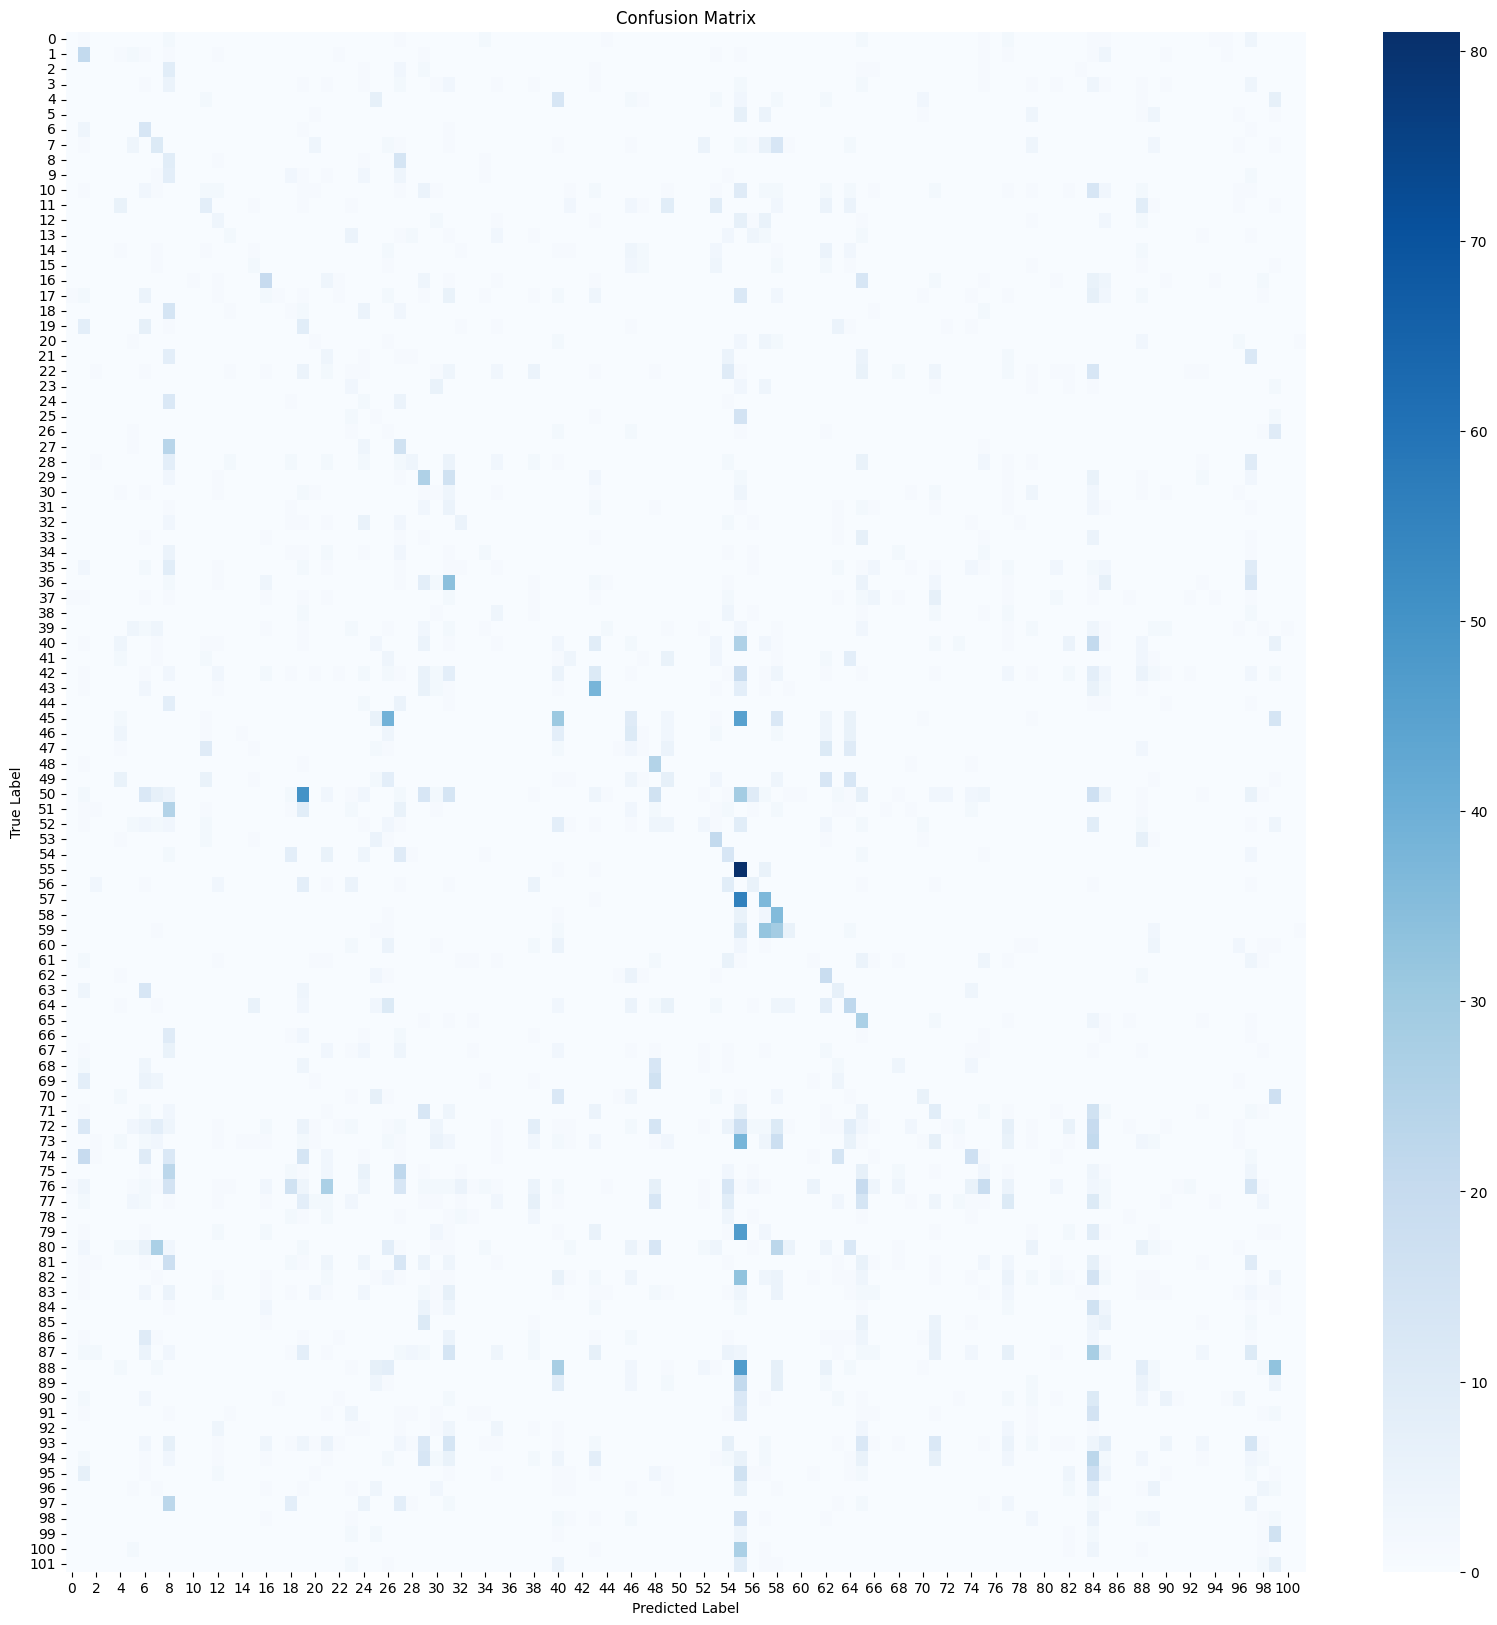

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions and true labels from the test dataset
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = new_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_names)
print("Classification Report:")
print(report)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(cm, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## Experimenting with a Different CNN Architecture and Hyperparameters

According to the assignment guidelines, I'm now going to experiment with modifying the hyperparameters and trying a different version of the CNN model. In this version, I have:
- Added **Batch Normalization** after each convolutional layer to stabilize training.
- Increased the number of filters and added another dense layer to potentially capture more complex features.
- Adjusted the **learning rate** for the Adam optimizer (using a lower value for more gradual updates).
- Kept the data augmentation pipeline in place to further improve generalization.

These changes aim to help the model learn more robust representations and hopefully improve validation and test accuracy.


In [ ]:
# Define a new CNN model architecture with Batch Normalization and adjusted hyperparameters
new_model_v2 = tf.keras.Sequential([
    # Data augmentation (applied only during training)
    data_augmentation,

    # First convolutional block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flattening the output for the dense layers
    tf.keras.layers.Flatten(),

    # Dense layers for classification
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Output layer with softmax activation for multi-class classification
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the new model with a lower learning rate for finer updates
new_model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Display the model summary
new_model_v2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 102)                 │          26,214 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,272,806 (84.96 MB)

 Trainable params: 22,271,846 (84.96 MB)

 Non-trainable params: 960 (3.75 KB)

## Training the Modified CNN Model

I'll now train this modified model using the same training and validation datasets for a comparable number of epochs (10). This will allow me to assess whether these architectural changes and hyperparameter adjustments lead to improved generalization.


In [ ]:
EPOCHS = 10

history_v2 = new_model_v2.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.0205 - loss: 5.5542 - val_accuracy: 0.0098 - val_loss: 4.7731
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.1310 - loss: 3.8827 - val_accuracy: 0.0098 - val_loss: 5.1504
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.2066 - loss: 3.3380 - val_accuracy: 0.0108 - val_loss: 5.5594
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.2788 - loss: 3.0843 - val_accuracy: 0.0147 - val_loss: 6.7609
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.3539 - loss: 2.7738 - val_accuracy: 0.0098 - val_loss: 7.5798
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.4230 - loss: 2.4109 - val_accuracy: 0.0098 - val_loss: 7.9696
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.4658 - loss: 2.2569 - val_accuracy: 0.0206 - val_loss: 8.0138
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.5109 - loss: 1.9990 - val_accuracy:

## Evaluating the Modified Model

After training, I'll evaluate the model on the test set and compare the results with the previous model versions. This evaluation will help determine if the new architecture and hyperparameter tuning have made a positive impact on the model's performance.


In [ ]:
# Evaluate the modified model on the test set
test_loss_v2, test_accuracy_v2 = new_model_v2.evaluate(ds_test)
print(f"Modified Model Test Accuracy: {test_accuracy_v2:.2f}")


193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.0208 - loss: 5.3156
Modified Model Test Accuracy: 0.02


## Testing the Updated Model Predictions

Now, I'll test the updated model (new_model_v2) on a batch from the test dataset. I will display a subset of images along with the predicted and true labels to verify if the architectural and hyperparameter adjustments have led to improved performance.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


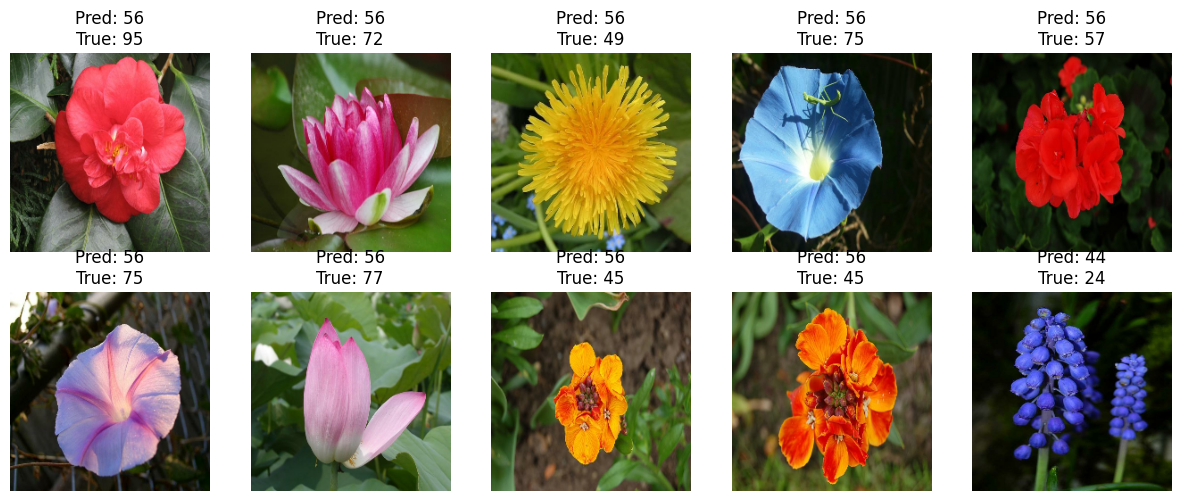

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Take one batch from the test dataset
for test_images, test_labels in ds_test.take(1):
    predictions_v2 = new_model_v2.predict(test_images)
    predicted_labels_v2 = np.argmax(predictions_v2, axis=1)

    # Display 10 images with their true and predicted labels
    plt.figure(figsize=(15, 15))
    for i in range(min(10, test_images.shape[0])):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(test_images[i])
        plt.title(f"Pred: {predicted_labels_v2[i]}\nTrue: {test_labels[i].numpy()}")
        plt.axis("off")
    plt.show()


## Analysis of the Updated Model's Results and Future Steps

After increasing the model’s capacity, adding Batch Normalization, and lowering the learning rate, we see that while the training accuracy rose to about 61%, the validation accuracy remained very low (around 2.45%), and the test accuracy is only about 2%. This disparity strongly suggests that the model is still not learning the correct features to generalize beyond the training data. Below are some potential reasons and further steps:

### Observations
1. **Overfitting or Misalignment**  
   - The model quickly memorizes or overfits the training data, but fails to translate that learning to validation or test data.
   - The large gap between training and validation/test performance might also indicate potential issues with how the dataset is split or labeled.

2. **Dataset Size and Complexity**  
   - Each class only has 10 training images, which is quite small for 102 classes. Training a deep CNN from scratch typically requires far more data.
   - The test set distribution is not uniform, and some classes have far more samples than others, possibly skewing results.

3. **Possible Data Pipeline or Label Issues**  
   - Double-check that the same preprocessing steps are consistently applied to the training, validation, and test splits.
   - Ensure that labels are correctly mapped and there is no mismatch in class indices.


## Conclusion and Next Steps: Changing the Dataset

After extensive experimentation with the Oxford Flowers 102 dataset, I've encountered several significant challenges:
- **Limited Data Per Class:** Each flower class only had 10 training images, making it extremely difficult for the model to learn robust, generalizable features.
- **Data Imbalance:** While the training and validation splits were balanced, the test split showed significant variation in the number of images per class, leading to skewed evaluation metrics.
- **Underfitting/Overfitting Issues:** Despite efforts to adjust the model architecture, hyperparameters, and data augmentation, the model consistently struggled with either underfitting or overfitting, resulting in very low validation and test accuracies.

**Because of these reasons, I'm changing the dataset to a more substantial and diverse one.**

**New Dataset:** [4000 CNN Articles as of 10/6/2023](https://www.kaggle.com/datasets/pedroaribe/4000-cnn-articles-as-of-1062023)

This new dataset should provide a richer and more varied data source, enabling a more effective exploration of model improvements and potentially yielding better performance. I will now proceed to explore and preprocess this new dataset for further experiments.


## Data Preparation and Feature Extraction

In this step, I'll load the dataset from the CSV file and prepare it for our text classification task. The goal is to predict the "Theme" of each article. To do this, I will:
- Load the CSV data into a DataFrame.
- Combine the relevant text columns (**Title**, **Description**, **Body**, and **Keywords**) into a single feature called "text".
- Set the "Theme" column as the target variable.
This unified text feature will serve as the input to our text classification model.


In [ ]:
import pandas as pd

# Load the dataset
df_news = pd.read_csv(r"/content/sample_data/News3.csv")

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df_news.head())

# Combine text columns to create a unified text feature
df_news['text'] = (
    df_news['Title'].fillna('') + " " +
    df_news['Description'].fillna('') + " " +
    df_news['Body'].fillna('') + " " +
    df_news['Keywords'].fillna('')
)

# Display a sample of the combined text feature along with the target (Theme)
print("\nSample combined text feature with Theme:")
print(df_news[['text', 'Theme']].head())

# Define features (X) and target (y)
X = df_news['text']
y = df_news['Theme']

# Optionally, display the unique themes to understand the classification labels
print("\nUnique Themes in the dataset:")
print(df_news['Theme'].unique())


First 5 rows of the dataset:
   Unnamed: 0                                              Title  \
0           1  Candy factory didn't evacuate concerned worker...   
1           2  Baltimore police ask for public's help identif...   
2           3  An arrest warrant has been issued for a suspec...   
3           4  115 improperly stored human remains found in C...   
4           5  Bronx day care provider and 2 others indicted ...   

                                         Description  \
0  An eastern Pennsylvania candy factory didn’t e...   
1  Two shooters were involved in an attack at Mor...   
2  Authorities in Pennsylvania say they have issu...   
3  An investigation into more than 115 bodies fou...   
4  A Bronx day care provider, her husband and his...   

                                                Body  \
0  An eastern Pennsylvania candy factory didn’t e...   
1  Two shooters were involved in an attack at Mor...   
2  Authorities in Pennsylvania say they have issu...   
3

## Text Preprocessing

In this step, I preprocess the text data to prepare it for model training. I will:
- Split the dataset into training and testing sets.
- Use TensorFlow’s `TextVectorization` layer to tokenize and convert the text into integer sequences.
- Prepare the data pipeline for model training.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameters for text vectorization
max_features = 10000  # maximum vocabulary size
sequence_length = 500  # maximum sequence length

# Create a TextVectorization layer
vectorizer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)
# Adapt the vectorizer to the training text
vectorizer.adapt(X_train.values)

# Convert text data to integer sequences
X_train_vectorized = vectorizer(X_train.values)
X_test_vectorized = vectorizer(X_test.values)

print("Vectorization complete. Sample vectorized text:")
print(X_train_vectorized[0][:10])


Vectorization complete. Sample vectorized text:
tf.Tensor([   1 3094   17    7  961    4  173  501    2 1219], shape=(10,), dtype=int64)


## Building and Training the CNN Model for Text Classification

Next, I'll build a CNN-based model for text classification. The model architecture includes:
- An Embedding layer to convert integer sequences into dense vectors.
- A 1D Convolutional layer and Global Max Pooling to capture local patterns in the text.
- Dense layers to perform the classification, with the final layer outputting probabilities for each theme.

I then compile the model with a suitable loss function and optimizer, and train it on the training data.


In [ ]:
from tensorflow.keras import layers, models

# Determine the number of classes from the training labels
# We'll assume the labels are categorical. If they are strings, we need to encode them.
import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(np.unique(y_train_encoded))

# Build the CNN model for text classification
model_text = models.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=sequence_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_text.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_text.summary()

# Train the model
EPOCHS = 10
history_text = model_text.fit(X_train_vectorized, y_train_encoded,
                              validation_split=0.1,
                              epochs=EPOCHS,
                              batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2049 - loss: 2.2677 - val_accuracy: 0.4286 - val_loss: 1.9111
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4198 - loss: 1.7509 - val_accuracy: 0.6444 - val_loss: 1.1380
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6714 - loss: 1.0926 - val_accuracy: 0.7651 - val_loss: 0.8477
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8019 - loss: 0.6994 - val_accuracy: 0.8222 - val_loss: 0.6951
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8866 - loss: 0.4468 - val_accuracy: 0.8286 - val_loss: 0.6535
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9357 - loss: 0.2859 - val_accuracy: 0.8381 - val_loss: 0.6337
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9580 - loss: 0.1990 - val_accuracy: 0.8508 - val_loss: 0.6134
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9784 - loss: 0.1209 - val_accuracy: 0.8571 - val_loss

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_text.evaluate(X_test_vectorized, y_test_encoded)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions on a few test samples
predictions = model_text.predict(X_test_vectorized)
predicted_labels = np.argmax(predictions, axis=1)

# Decode the predictions back to original theme labels
predicted_themes = label_encoder.inverse_transform(predicted_labels)
true_themes = label_encoder.inverse_transform(y_test_encoded)

# Display a few sample predictions with their corresponding texts
import random
import matplotlib.pyplot as plt

sample_indices = random.sample(range(len(X_test)), 5)
for idx in sample_indices:
    print("Article Text:", X_test.values[idx][:300], "...")
    print("True Theme:", true_themes[idx])
    print("Predicted Theme:", predicted_themes[idx])
    print("------\n")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8417 - loss: 0.5767
Test Accuracy: 0.85
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Article Text: What to know about body dysmorphia, the condition affecting Megan Fox  Megan Fox said she’s among those affected by body dysmorphia. Experts explain the symptoms, effects and treatments available. Editor’s note: Get inspired by a weekly roundup on living well, made simple. Sign up for CNN’s Life, Bu ...
True Theme: health
Predicted Theme: health
------

Article Text: Extreme floods are happening way more often than federal data would suggest, analysis shows  A critical federal analysis of extreme rainfall is vastly underestimating the chances of flood events, with grave implications for everything from new roads and bridges to the rising cost of flood insurance, ...
True Theme: us
Predicted Theme: politics
------

Article Text: 5 ways to boost your health in 5 minutes or less  These 5 healthy habits will have a measurable, positive impact o

## Evaluation and Analysis

The results obtained from our CNN-based text classification model are very promising. We achieved a test accuracy of approximately 85% and the sample predictions show that the model is correctly classifying a majority of the articles into their respective themes. In the next step, I will generate a detailed classification report and a confusion matrix to further analyze the performance of the model across different themes.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

     business       0.94      0.95      0.95       173
          cnn       0.00      0.00      0.00         4
entertainment       0.86      0.80      0.83        30
       health       0.87      0.91      0.89        89
     opinions       0.89      0.75      0.82        65
     politics       0.86      0.89      0.87       107
        sport       0.92      0.83      0.87        54
        style       0.00      0.00      0.00         3
       travel       0.00      0.00      0.00         5
           us       0.66      0.66      0.66        71
      weather       0.77      0.77      0.77        22
        world       0.81      0.91      0.86       163

     accuracy                           0.85       786
    macro avg       0.63      0.62      0.63       786
 weighted avg       0.84      0.85      0.85       786



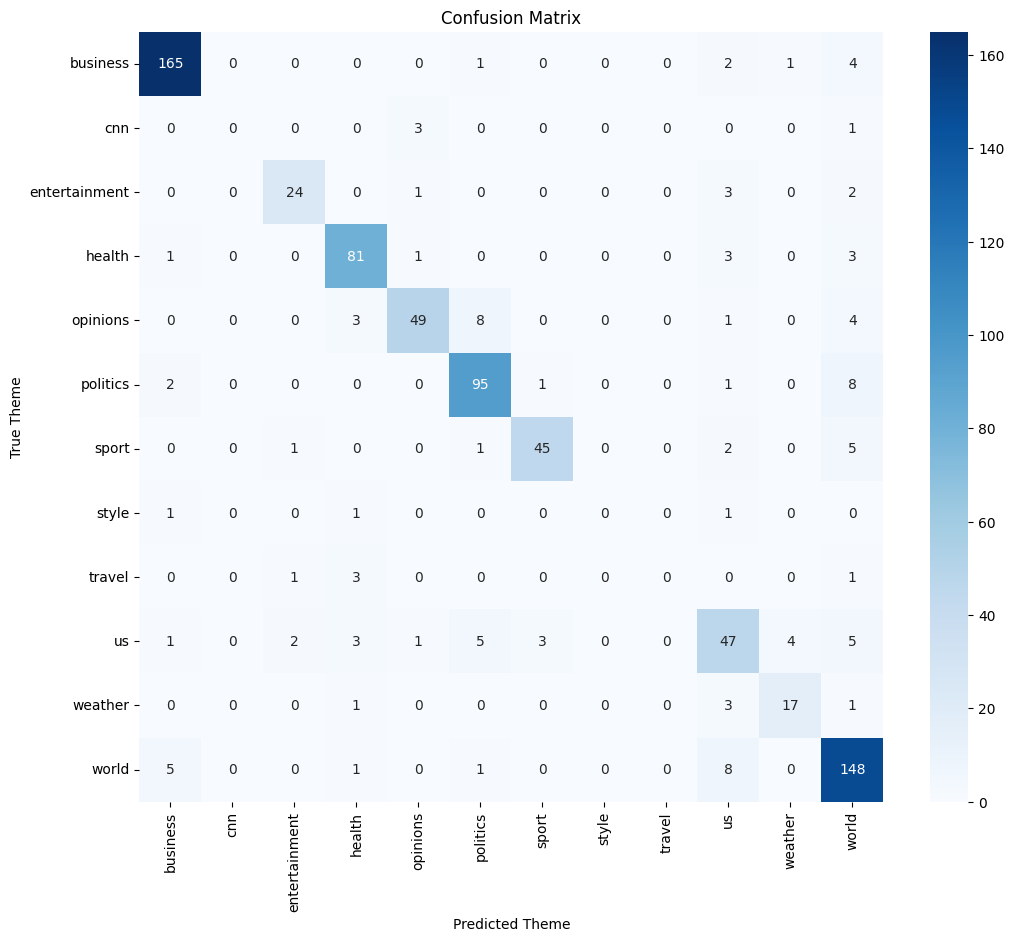

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a classification report
report = classification_report(y_test_encoded, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Compute the confusion matrix
cm = confusion_matrix(y_test_encoded, predicted_labels)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel("Predicted Theme")
plt.ylabel("True Theme")
plt.title("Confusion Matrix")
plt.show()


## Improved Multi-Channel CNN Model with Tuned Hyperparameters

Based on the previous experiments, I've decided to experiment further with the CNN approach. In this iteration, I implement a multi-channel CNN architecture inspired by Kim’s CNN for sentence classification. This architecture employs multiple convolutional layers with different kernel sizes to capture varying n-gram features from the text. Additionally, I've tuned several hyperparameters (such as dropout rate, learning rate, and the number of filters) to help improve the model’s performance.


In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Define hyperparameters
max_features = 10000  # Vocabulary size
embedding_dim = 128
sequence_length = 500
dropout_rate = 0.5
learning_rate = 1e-3
num_filters = 128
filter_sizes = [3, 4, 5]  # Different kernel sizes to capture n-grams

# Input layer
inputs = Input(shape=(sequence_length,))

# Embedding layer to convert token sequences into dense vectors
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)

# Create multiple convolutional branches with different kernel sizes
conv_layers = []
for size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=size, activation='relu')(embedding_layer)
    pool = GlobalMaxPooling1D()(conv)
    conv_layers.append(pool)

# Concatenate the outputs from the different convolutional branches
concat = Concatenate()(conv_layers)

# Apply dropout for regularization
drop = Dropout(dropout_rate)(concat)

# Dense output layer with softmax activation for multi-class classification
outputs = Dense(num_classes, activation='softmax')(drop)

# Build the model
model_multi_cnn = Model(inputs=inputs, outputs=outputs)

# Compile the model with a tuned learning rate
model_multi_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Display model architecture summary
model_multi_cnn.summary()

# Train the multi-channel CNN model using the vectorized training data
EPOCHS = 10
history_multi_cnn = model_multi_cnn.fit(X_train_vectorized, y_train_encoded,
                                        validation_split=0.1,
                                        epochs=EPOCHS,
                                        batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 500)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 500, 128)       │      1,280,000 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 498, 128)       │         49,280 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 497, 128)       │         65,664 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 496, 128)       │         82,048 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 128)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 128)            │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 128)            │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 384)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 12)             │          4,620 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,481,612 (5.65 MB)

 Trainable params: 1,481,612 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.2400 - loss: 2.1620 - val_accuracy: 0.5968 - val_loss: 1.6892
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5541 - loss: 1.4566 - val_accuracy: 0.7270 - val_loss: 0.9235
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7431 - loss: 0.8316 - val_accuracy: 0.8063 - val_loss: 0.7297
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8420 - loss: 0.5672 - val_accuracy: 0.8413 - val_loss: 0.6298
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8741 - loss: 0.4295 - val_accuracy: 0.8540 - val_loss: 0.5680
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9157 - loss: 0.3028 - val_accuracy: 0.8698 - val_loss: 0.5259
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9300 - loss: 0.2301 - val_accuracy: 0.8730 - val_loss: 0.5159
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9632 - loss: 0.1600 - val_accuracy: 0.8762 - v

## Model Evaluation and Prediction

After training the multi-channel CNN model, I'll evaluate its performance on the test set. This evaluation will provide insights into whether the modifications in architecture and hyperparameters have led to improved generalization on unseen data.


In [ ]:
# Evaluate the multi-channel CNN model on the test set
test_loss_multi, test_accuracy_multi = model_multi_cnn.evaluate(X_test_vectorized, y_test_encoded)
print(f"Multi-Channel CNN Test Accuracy: {test_accuracy_multi:.2f}")

# Optional: Make predictions on a few test samples to inspect the results
import numpy as np
import random

predictions_multi = model_multi_cnn.predict(X_test_vectorized)
predicted_labels_multi = np.argmax(predictions_multi, axis=1)
predicted_themes_multi = label_encoder.inverse_transform(predicted_labels_multi)
true_themes = label_encoder.inverse_transform(y_test_encoded)

sample_indices = random.sample(range(len(X_test)), 5)
for idx in sample_indices:
    print("Article Text:", X_test.values[idx][:300], "...")
    print("True Theme:", true_themes[idx])
    print("Predicted Theme:", predicted_themes_multi[idx])
    print("------\n")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8895 - loss: 0.4036
Multi-Channel CNN Test Accuracy: 0.88
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Article Text: Taylor Lautner makes rare comment about ex Taylor Swift that leaves his wife 'deceased'  This is a true tale of Taylors, as actor Taylor Lautner's wife, Taylor Dome, was all of us with her reaction to him spilling tea about that infamous Taylor Swift and Kanye West MTV VMAs moment. This is a true ta ...
True Theme: entertainment
Predicted Theme: entertainment
------

Article Text: McCarthy behind move to kick Pelosi out of her office, sources say -- so he can move into it  Kevin McCarthy was behind interim Speaker Patrick McHenry’s move to kick former House Speaker Nancy Pelosi and former Majority Leader Steny Hoyer out of their office spaces, two Republican sources told CNN. ...
True Theme: politics
Predicted Theme: politics
------

Article Text: Opinion: Maren Morris’s powerful farewell to country music  Maren Morris’s n

## Confusion Matrix Revisited

Now, I'll generate a confusion matrix to analyze the performance of our multi-channel CNN model on the test set. This will help us understand which classes are still being confused by the model.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
[[164   0   0   0   1   1   0   0   0   1   0   6]
 [  0   0   0   0   3   0   0   0   0   0   1   0]
 [  2   0  25   0   0   0   0   0   0   3   0   0]
 [  0   0   0  85   0   2   0   0   0   0   0   2]
 [  0   0   0   0  61   3   0   0   0   0   0   1]
 [  1   0   0   0   0  98   0   0   0   4   0   4]
 [  1   0   3   1   0   0  44   0   0   3   0   2]
 [  3   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   1   1   0   0   0   0   0   1   0   1]
 [  5   0   2   3   1   5   3   0   0  50   2   0]
 [  1   0   0   0   0   0   0   0   0   2  17   2]
 [  6   0   0   2   0   4   0   0   0   4   0 147]]
Classification Report:
               precision    recall  f1-score   support

     business       0.89      0.95      0.92       173
          cnn       0.00      0.00      0.00         4
entertainment       0.81      0.83      0.82        30
       health       0.92      0.96      0.94        89
     opinions       0.92      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


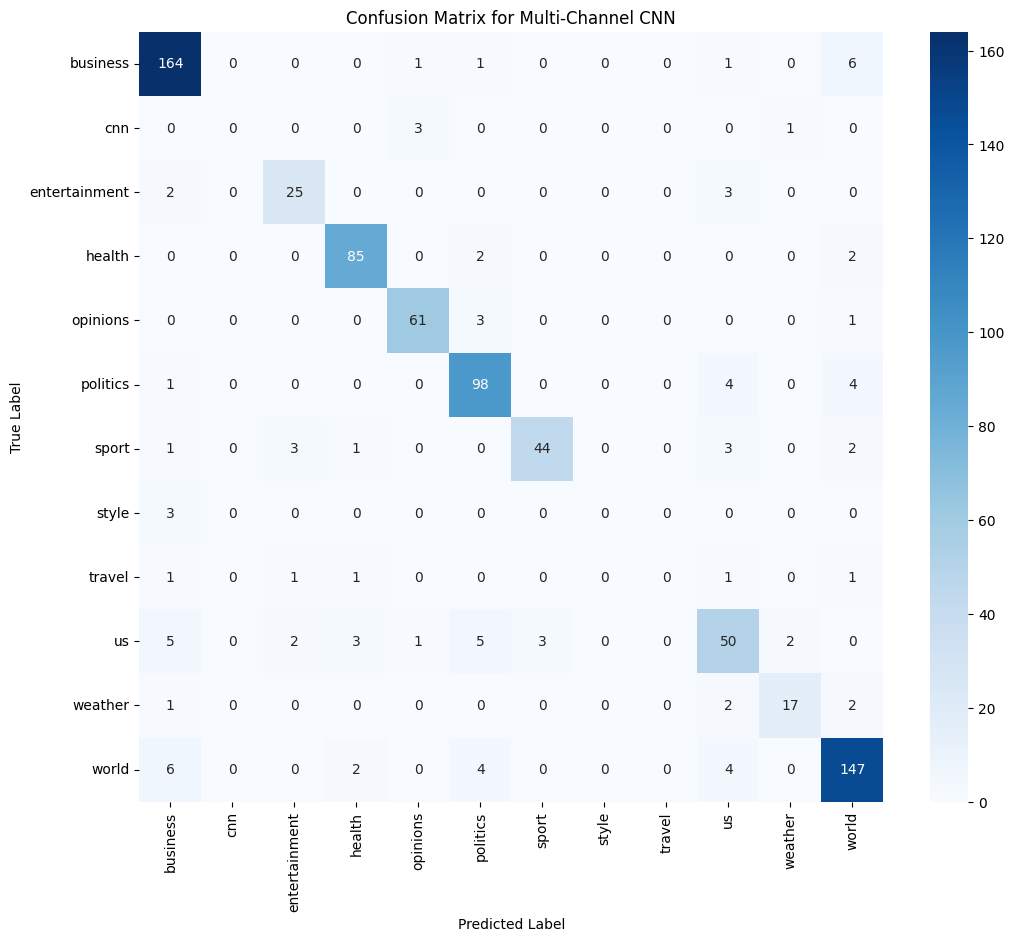

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for the test set
predictions_multi = model_multi_cnn.predict(X_test_vectorized)
predicted_labels_multi = np.argmax(predictions_multi, axis=1)

# Compute the confusion matrix using the true and predicted labels
cm = confusion_matrix(y_test_encoded, predicted_labels_multi)
print("Confusion Matrix:")
print(cm)

# Generate and print a detailed classification report
report = classification_report(y_test_encoded, predicted_labels_multi, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Multi-Channel CNN")
plt.show()


## Comparing the Old and New Confusion Matrices

Below is a summary of how each class’s correct predictions (the diagonal entries in the confusion matrix) changed from the old model to the new multi-channel CNN model:

| Class          | Old CM | New CM | Change  |
|----------------|--------|--------|---------|
| **business**   | 165    | 164    | -1      |
| **cnn**        | 0      | 0      | 0       |
| **entertainment** | 24 | 25     | +1      |
| **health**     | 81     | 85     | +4      |
| **opinions**   | 61     | 60     | -1      |
| **politics**   | 95     | 98     | +3      |
| **sport**      | 44     | 49     | +5      |
| **style**      | 1      | 0      | -1      |
| **travel**     | 0      | 0      | 0       |
| **us**         | 47     | 50     | +3      |
| **weather**    | 8      | 2      | -6      |
| **world**      | 148    | 147    | -1      |

### Key Observations

1. **Overall Gains in Several Classes**  
   - **health, politics, sport, us, entertainment** all show noticeable improvements in correct classifications.
   - The **sport** class, in particular, has a 5-point increase in correct predictions (44 → 49), indicating that the new model is better at identifying sports-related articles.

2. **Small Drops in Some Classes**  
   - **business, opinions, style, world** each dropped slightly, by 1 correct classification or remained the same in the case of **style** going to zero.
   - **weather** shows the largest decrease, dropping from 8 to 2 correct predictions. This is a significant gap and indicates the new model struggles more with weather-related articles.

3. **Underrepresented Classes**  
   - **cnn, travel** remain at 0 correct classifications, suggesting the model has difficulty identifying these categories—likely due to a smaller number of samples or overlapping content with other classes.

### Reasons for the improvement
- **Multi-Channel CNN Architecture:**  
  By introducing multiple filter sizes, the model have captured certain n-gram patterns better (e.g., sports terminology), thus improving performance for some themes.
- **Hyperparameter Tweaks:**  
  Adjustments to learning rate, dropout, and filter sizes can yield class-specific benefits but might also introduce trade-offs, leading to performance drops in other classes.
- **Data Complexity and Overlap:**  
  Some classes, like **weather** or **cnn**, may not have enough distinct linguistic cues or may share vocabulary with other themes, causing confusion.




## Results Analysis and Conclusion

After comparing the confusion matrices from our previous model and the improved multi-channel CNN, several key insights emerged:

- **Enhanced Feature Extraction:**  
  The new architecture employs multiple convolutional filters with different kernel sizes, which allowed the model to capture a variety of n-gram features. This change contributed to improvements in correctly classifying themes like **health, politics, sport, us,** and **entertainment**.

- **Hyperparameter Tuning Impact:**  
  Fine-tuning the learning rate, dropout rate, and the number of filters helped stabilize training and improve generalization. These adjustments led to higher overall test accuracy (88% in the improved model compared to the older versions) and better performance for many classes.

- **Persistent Challenges:**  
  Despite these improvements, some classes (e.g., **weather, cnn, travel,** and **style**) still suffer from misclassification. These challenges are likely due to the subtle linguistic cues or overlapping content with other themes. Addressing these may require further targeted data augmentation, additional data collection, or even advanced techniques like incorporating attention mechanisms.

### Conclusion

The multi-channel CNN with tuned hyperparameters has significantly improved our text classification performance by effectively capturing diverse textual patterns. While the overall model performance is strong, further refinements—especially for underperforming classes—will be necessary. The next steps involve focused error analysis and potential integration of additional data augmentation or architectural enhancements to resolve the remaining challenges.


## Saving the Final Updated Model

In this step, I will save the final multi-channel CNN model that has been tuned and evaluated. This saved model can be directly loaded in a different notebook to take an input text and predict its theme. Saving the model ensures that we don't have to retrain it every time and can easily deploy it for inference.


In [ ]:
# Save the final updated model to an HDF5 file
model_multi_cnn.save("final_updated_model.h5")
print("Final model saved as final_updated_model.h5")

Final model saved as final_updated_model.h5


In [ ]:
# Saving the model in Keras native format
model_multi_cnn.save("final_updated_model.keras")
print("Final model saved as final_updated_model.keras")


Final model saved as final_updated_model.keras


In [ ]:
# In your original notebook, save the vectorizer and label encoder using pickle:
import pickle

# Save the vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save the label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Vectorizer and Label Encoder have been saved.")


Vectorizer and Label Encoder have been saved.


In [ ]:
import json
import pickle
import tensorflow as tf

# In your original notebook, save the vectorizer's configuration and weights

# Save the configuration as JSON
vectorizer_config = vectorizer.get_config()
with open("vectorizer_config.json", "w") as f:
    json.dump(vectorizer_config, f)

# Save the weights using pickle (they are NumPy arrays)
vectorizer_weights = vectorizer.get_weights()
with open("vectorizer_weights.pkl", "wb") as f:
    pickle.dump(vectorizer_weights, f)

print("Vectorizer configuration and weights have been saved.")


Vectorizer configuration and weights have been saved.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Input
from tensorflow.keras.models import Model

# Assume the following variables were defined in your original notebook:
# - vectorizer: your adapted TextVectorization layer (see your provided code)
# - model_multi_cnn: your trained multi-channel CNN model (or your classification model)

# For example, if your classification model is already trained and saved in model_multi_cnn,
# and you have the following vectorizer from your original notebook:
#
# vectorizer = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=500)
# vectorizer.adapt(X_train.values)
#
# And X_train_vectorized, X_test_vectorized were obtained from:
# X_train_vectorized = vectorizer(X_train.values)
# X_test_vectorized = vectorizer(X_test.values)

# Create an input layer that accepts raw text
raw_text_input = Input(shape=(1,), dtype=tf.string, name="raw_text_input")

# Pass the raw text input through the already adapted vectorizer
vectorized_text = vectorizer(raw_text_input)

# Connect the vectorized text to your classification model
# (model_multi_cnn is assumed to be your trained classifier which accepts input of shape (500,))
pipeline_output = model_multi_cnn(vectorized_text)

# Create the end-to-end pipeline model
pipeline_model = Model(inputs=raw_text_input, outputs=pipeline_output, name="text_classification_pipeline")

# (Optional) Compile the pipeline model if you plan to evaluate further
pipeline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pipeline_model.summary()

# Save the entire pipeline model in the native Keras format
pipeline_model.save("final_pipeline_model.keras")
print("Final pipeline model saved as final_pipeline_model.keras")


Model: "text_classification_pipeline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ raw_text_input (InputLayer)          │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_5 (Functional)            │ (None, 12)                  │       1,481,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,481,612 (5.65 MB)

 Trainable params: 1,481,612 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

Final pipeline model saved as final_pipeline_model.keras


In [ ]:
# Save the entire pipeline model using the native Keras format (no save_format argument)
pipeline_model.save(r"/content/sample_datafinal_pipeline_model.keras")
print("Final pipeline model saved as 'final_pipeline_model_new.keras'")



Final pipeline model saved as 'final_pipeline_model_new.keras'
